## RQ3 Full Process

This script provides the analysis for **RQ3: How does the way people value forest relate to forest definition?** It builds off the outputs from the first two research questions to explore whether there are differnces in the cluster composition in areas where there is consensus on forest presence compared to areas where there is no consensus.

Steps:
- Load the tokens for class 3 and 6 (created in RQ2)
- Assign each token their cluster from RQ2
- Isolate the clusters of interest
- Compare those clusters (word cloud, cluster size, token frequency)

**IMPORTANT** When using only trails that intersect with Natura sites, the number of trails for class 3 is very low (67). Because there is so little data for class 3, the results aren't very meaningful. In addition to this old approach, I therefore also expand the trail filter to include trails which do not intersect with Natura sites (but are still filtered according to their max class in the forest consensus map). Unfortunately there are still relatively few trails/tokens for class 3 compared to class 6, but I continued with this approach. I use the clusters from RQ2 so any new tokens not included in the Natura-only clustering are not represented here - in this way I'm still looking at the clusters/tokens that are relevant to Natura but applying them to trails outside Natura as well.

In [1]:
# SETUP

# Import packages
import pandas as pd
import pickle

import spacy
from deep_translator import GoogleTranslator
from collections import Counter

import matplotlib.pyplot as plt
from wordcloud import WordCloud


### Step 1: Load tokens for class 3 and 6

These were created as part of RQ2. They are separated by class and also by whether they intersect with Natura sites ("natura") or not ("non-natura").

In [2]:
# STEP 1: LOAD & COMBINE CLASS TOKENS

# Load class 3 and 6 Natura tokens
filtered_tokens_nat_c3 = pickle.load(open("./processing/final_tokens_nat_c3.p", "rb"))
filtered_tokens_nat_c6 = pickle.load(open("./processing/final_tokens_nat_c6.p", "rb"))

# Load class 3 and 6 Non-Natura tokens
filtered_tokens_nonnat_c3 = pickle.load(open("./processing/final_tokens_nonnat_c3.p", "rb"))
filtered_tokens_nonnat_c6 = pickle.load(open("./processing/final_tokens_nonnat_c6.p", "rb"))

# Combine Natura and Non-Natura tokens
filtered_tokens_all_c3 = filtered_tokens_nat_c3 + filtered_tokens_nonnat_c3
filtered_tokens_all_c6 = filtered_tokens_nat_c6 + filtered_tokens_nonnat_c6


In [4]:
# STEP 1: CHECK GENERAL RESULTS

# Count the top 5 most common words across Natura class 3 tokens
word_freq_nat_c3 = Counter(filtered_tokens_nat_c3)
common_words_nat_c3 = word_freq_nat_c3.most_common(5)

# Count the top 5 most common words across Natura class 6 tokens
word_freq_nat_c6 = Counter(filtered_tokens_nat_c6)
common_words_nat_c6 = word_freq_nat_c6.most_common(5)

# Count the top 5 most common words across all class 3 tokens
word_freq_c3 = Counter(filtered_tokens_all_c3)
common_words_c3 = word_freq_c3.most_common(5)

# Count the top 5 most common words across all class 6 tokens
word_freq_c6 = Counter(filtered_tokens_all_c6)
common_words_c6 = word_freq_c6.most_common(5)

# Show the most common words for each class
print("Top 5 most common words for Natura class 3: ", common_words_nat_c3 )
print("Top 5 most common words for Natura class 6: ", common_words_nat_c6 )
print("--------------------------------------")
print("Top 5 most common words for ALL class 3: ", common_words_c3 )
print("Top 5 most common words for ALL class 6: ", common_words_c6 )


Top 5 most common words for Natura class 3:  [('wanderung', 9), ('weg', 6), ('to', 5), ('entlang', 4), ('rauhkopf', 4)]
Top 5 most common words for Natura class 6:  [('weg', 154), ('blick', 113), ('aussicht', 101), ('parkplatz', 84), ('burg', 82)]
--------------------------------------
Top 5 most common words for ALL class 3:  [('wanderung', 17), ('weg', 12), ('runde', 10), ('schöne', 9), ('entlang', 8)]
Top 5 most common words for ALL class 6:  [('weg', 205), ('blick', 143), ('wald', 131), ('parkplatz', 119), ('aussicht', 117)]


### Step 2: Assign clusters

Assign each token their cluster from RQ2. This involves loading the previously created tokens with their cluster label and then matching the class 3 and 6 token sets to these clusters. Again, not all class 3 and 6 tokens will be carried through after this matching because a) the token set for RQ3 is based on Natura AND non-Natura trails (whereas the clusters are made from only trails which intersect with Natura); and b) tokens are not always present in the word2vec model (same as with RQ2).

In [5]:
# STEP 2: LOAD TOKEN/CLUSTER LOOKUP FROM RQ2

# Load the token/cluster df
token_cluster_lookup = pickle.load(open("./processing/token_cluster_all.p", "rb"))

# Convert to dictionary
token_cluster_lookup_dict = token_cluster_lookup.set_index("token").to_dict()["cluster"]

# Check
#token_cluster_lookup_dict

In [6]:
# STEP 2: MAP TOKENS TO CLUSERS

# Create a df with tokens as one column
# Natura only
final_tokens_natura_c3_df = pd.DataFrame({'token': filtered_tokens_nat_c3})
final_tokens_natura_c6_df = pd.DataFrame({'token': filtered_tokens_nat_c6})
# All 
final_tokens_c3_df = pd.DataFrame({'token': filtered_tokens_all_c3})
final_tokens_c6_df = pd.DataFrame({'token': filtered_tokens_all_c6})

# Add cluster column using dictionary as lookup
# Natura only
final_tokens_natura_c3_df["cluster"] = final_tokens_natura_c3_df["token"].map(token_cluster_lookup_dict)
final_tokens_natura_c6_df["cluster"] = final_tokens_natura_c6_df["token"].map(token_cluster_lookup_dict)
# All
final_tokens_c3_df["cluster"] = final_tokens_c3_df["token"].map(token_cluster_lookup_dict)
final_tokens_c6_df["cluster"] = final_tokens_c6_df["token"].map(token_cluster_lookup_dict)

# Remove NaN entries 
# these are ones that are not included in the RQ2 clusters (either because not in word2vec model 
# or because they are extra words from non-Natura sites that were not present in RQ2 clustering)
# Natura only
final_tokens_natura_c3_df = final_tokens_natura_c3_df.dropna()
final_tokens_natura_c6_df = final_tokens_natura_c6_df.dropna()
# All
final_tokens_c3_df = final_tokens_c3_df.dropna()
final_tokens_c6_df = final_tokens_c6_df.dropna()

# Convert cluster number to int
# Natura only
final_tokens_natura_c3_df["cluster"] = final_tokens_natura_c3_df["cluster"].astype(int)
final_tokens_natura_c6_df["cluster"] = final_tokens_natura_c6_df["cluster"].astype(int)
# All 
final_tokens_c3_df["cluster"] = final_tokens_c3_df["cluster"].astype(int)
final_tokens_c6_df["cluster"] = final_tokens_c6_df["cluster"].astype(int)

# Check
#final_tokens_c3_df

### Step 3: Isolate clusters of interest

For RQ3 I only focus on the clusters of interest for CES. For that reason I extract the following clusters:
- 3 "Aesthetic values 1 (adjectives)"
- 4 "Historical & religious values"
- 8 "Natural features"
- 11 "Aesthetic values 2 (visual perception)"

In [7]:
# STEP 3: FILTER SPECIFIC CLUSTERS

# Extract the clusters of interest
# Natura only
filtered_clusters_natura_c3 = final_tokens_natura_c3_df[(final_tokens_natura_c3_df["cluster"]==3) | (final_tokens_natura_c3_df["cluster"]==4) | (final_tokens_natura_c3_df["cluster"]==8) | (final_tokens_natura_c3_df["cluster"]==11)]
filtered_clusters_natura_c6 = final_tokens_natura_c6_df[(final_tokens_natura_c6_df["cluster"]==3) | (final_tokens_natura_c6_df["cluster"]==4) | (final_tokens_natura_c6_df["cluster"]==8) | (final_tokens_natura_c6_df["cluster"]==11)]
# All
filtered_clusters_c3 = final_tokens_c3_df[(final_tokens_c3_df["cluster"]==3) | (final_tokens_c3_df["cluster"]==4) | (final_tokens_c3_df["cluster"]==8) | (final_tokens_c3_df["cluster"]==11)]
filtered_clusters_c6 = final_tokens_c6_df[(final_tokens_c6_df["cluster"]==3) | (final_tokens_c6_df["cluster"]==4) | (final_tokens_c6_df["cluster"]==8) | (final_tokens_c6_df["cluster"]==11)]

# Check
#filtered_clusters_c3

### Step 4: Compare Class 3 and 6 Results

Create visualisations for comparing class 3 and 6 results.
- wordcloud
- bar chart for total tokens per cluster
- bar chart for token frequency per cluster

I generate the above for both the Natura only version, and the expanded version with both Natura and non-Natura trail text.

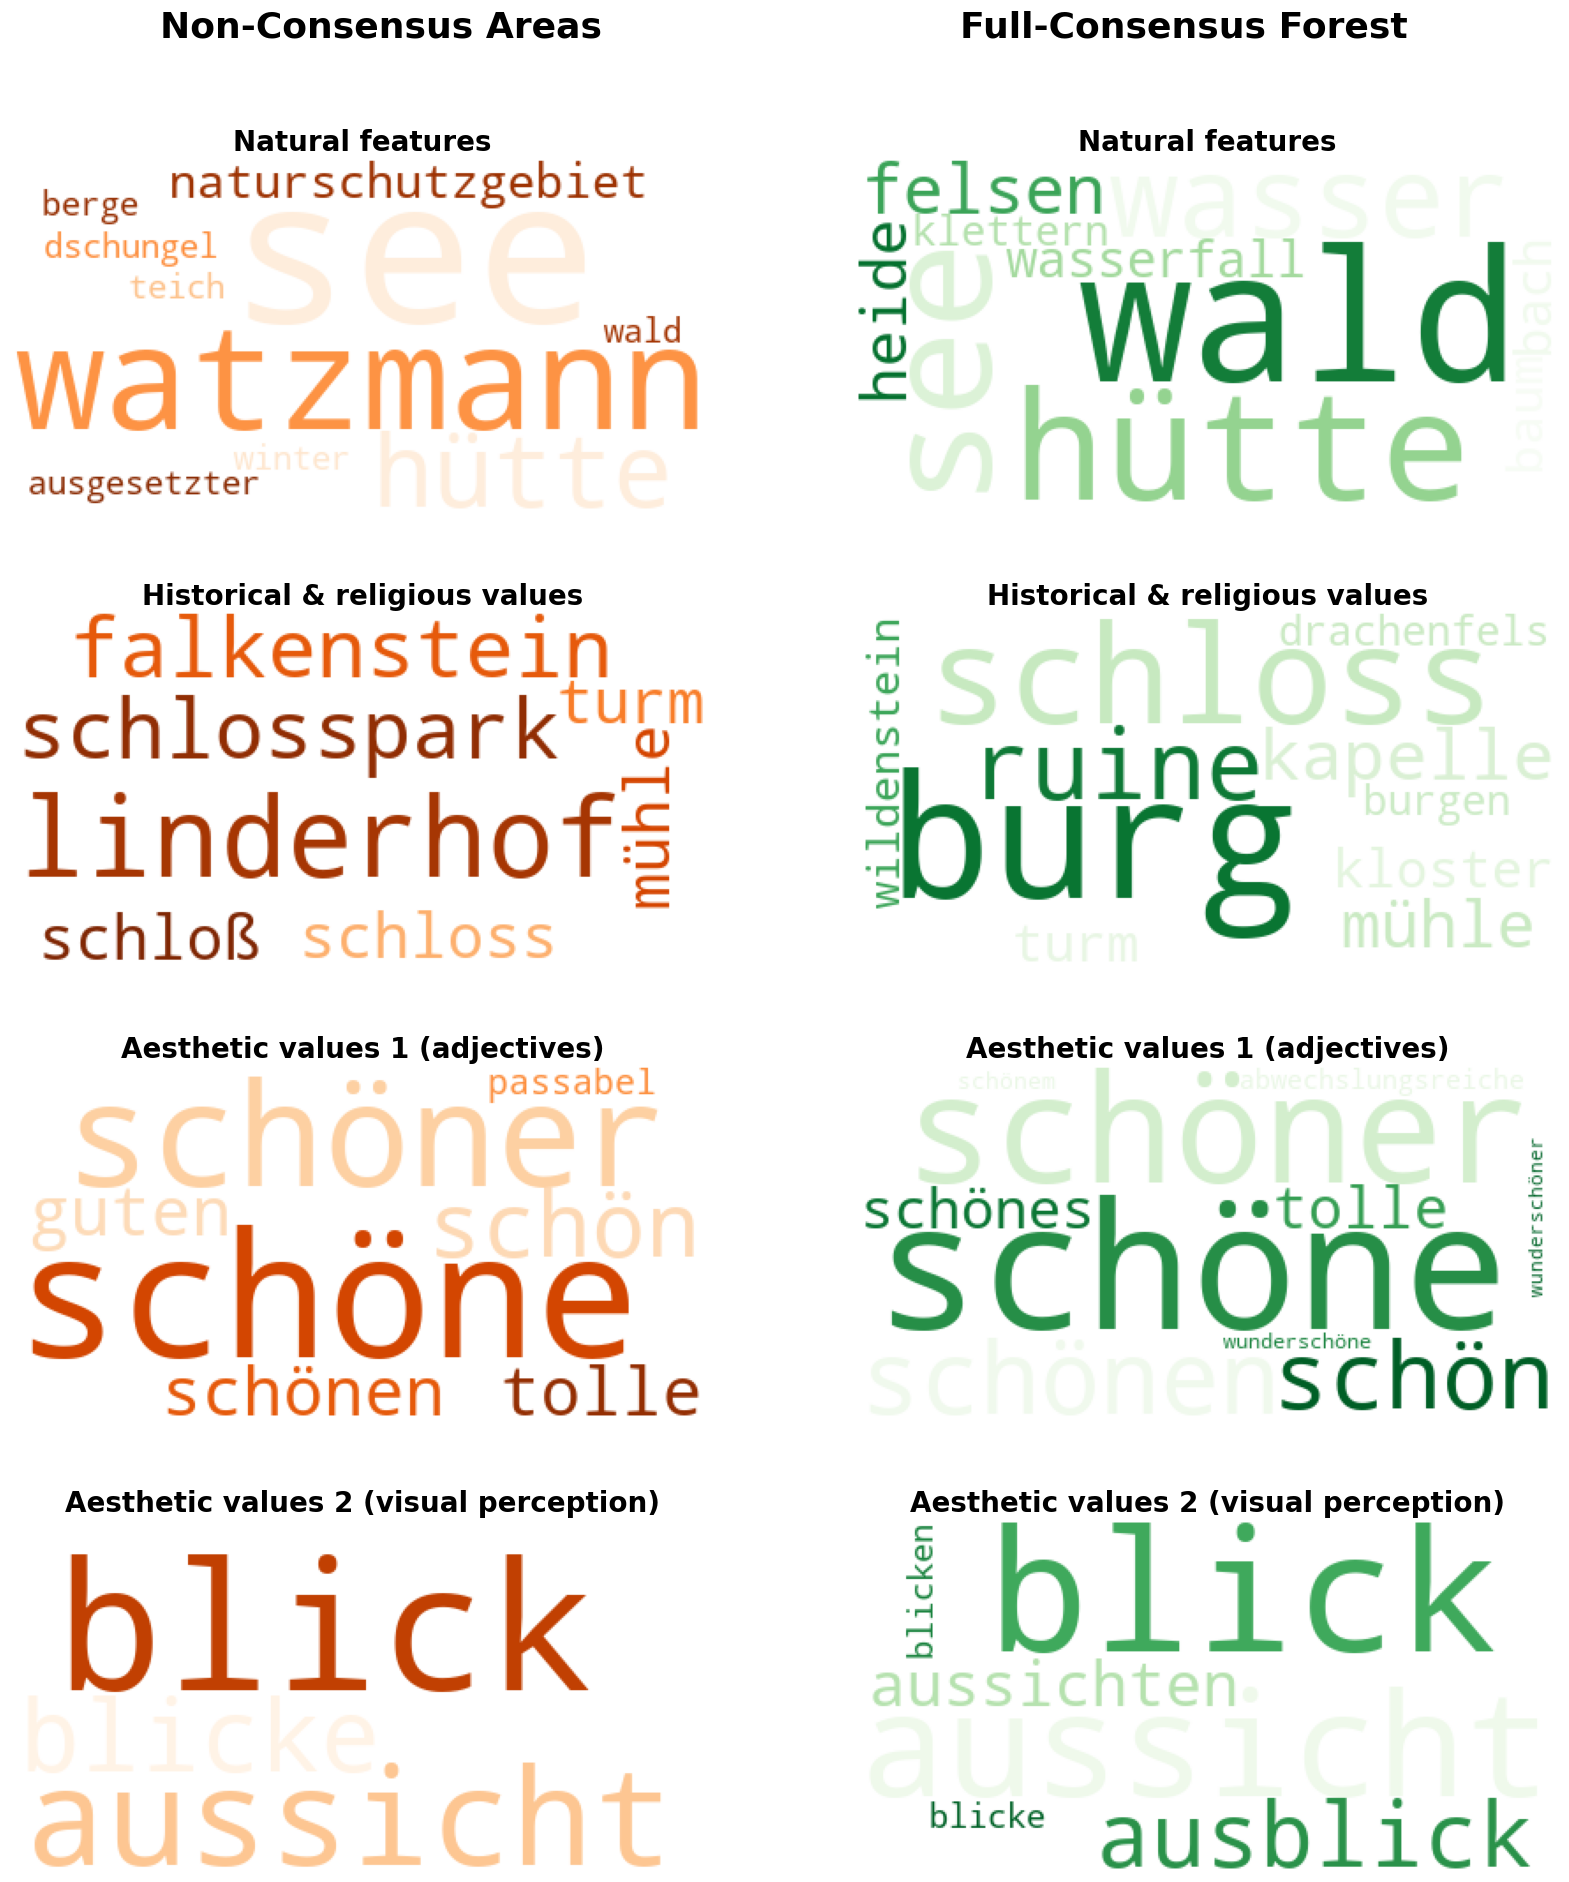

In [ ]:
# STEP 3: WORD CLOUDS (Natura only)

# Create a function to count the token frequencies for each cluster 
def get_cluster_freq(df, clus_num):
    token_list = df.loc[df["cluster"] == clus_num, "token"]
    delimiter = " " 
    join_str = delimiter.join(token_list)
    freqs = Counter(join_str.split())
    return freqs

# Create empty lists for storing the word cloud plots 
all_wc_nat_c3 = []
all_wc_nat_c6 = []

# For each cluster number use the get_cluster_freq function to get token frequencies,
# input those frequencies into the WordCloud generator and append each wc to list
# IMPORTANT: I HAVE LIMITED TO SHOW TOP 10 TOKENS IN EACH CLUSTER

# Generate class 3 word clouds (order is based on freq order from RQ2)
for clus_num in [8, 4, 3, 11]:  
    freqs = get_cluster_freq(filtered_clusters_natura_c3, clus_num)
    wc = WordCloud(background_color='white', 
                   colormap='Oranges', 
                   max_words=10).generate_from_frequencies(freqs)
    all_wc_nat_c3.append(wc)

# Generate class 6 word clouds (order is based on freq order from RQ2)
for clus_num in [8, 4, 3, 11]:  
    freqs = get_cluster_freq(filtered_clusters_natura_c6, clus_num)
    wc = WordCloud(background_color='white', 
                   colormap='Greens', 
                   max_words=10).generate_from_frequencies(freqs)
    all_wc_nat_c6.append(wc)

# Use the same titles AND order as from RQ2
all_titles = ["Natural features", "Historical & religious values", 
              "Aesthetic values 1 (adjectives)", "Aesthetic values 2 (visual perception)"]

# Create a single figure with 5 rows and 2 columns
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 22))

# Iterate through each word cloud to plot (class 3 in 1st column, class 6 in 2nd column) 
for i in range(4):
    # Class 3 word clouds
    axes[i, 0].imshow(all_wc_nat_c3[i])
    axes[i, 0].axis('off')
    axes[i, 0].set_title(all_titles[i], fontsize=20, fontweight="bold")

    # Class 6 word clouds
    axes[i, 1].imshow(all_wc_nat_c6[i])
    axes[i, 1].axis('off')
    axes[i, 1].set_title(all_titles[i], fontsize=20, fontweight="bold")

# Adjust white space at the top to fit in main titles and adjust space between rows
plt.subplots_adjust(top=0.90, hspace=0.2)

# Add column titles (first two numbers control the position)
fig.text(0.20, 0.95, "Non-consensus areas", fontsize=26, fontweight='bold')
fig.text(0.60, 0.95, "Full consensus forest", fontsize=26, fontweight='bold')

# Save the figure (this needs to go before plt.show otherwise saved output is blank)
plt.savefig('./outputs/figures/rq3_word_clouds_natura_only.png', bbox_inches='tight')

# Display figure
plt.show()

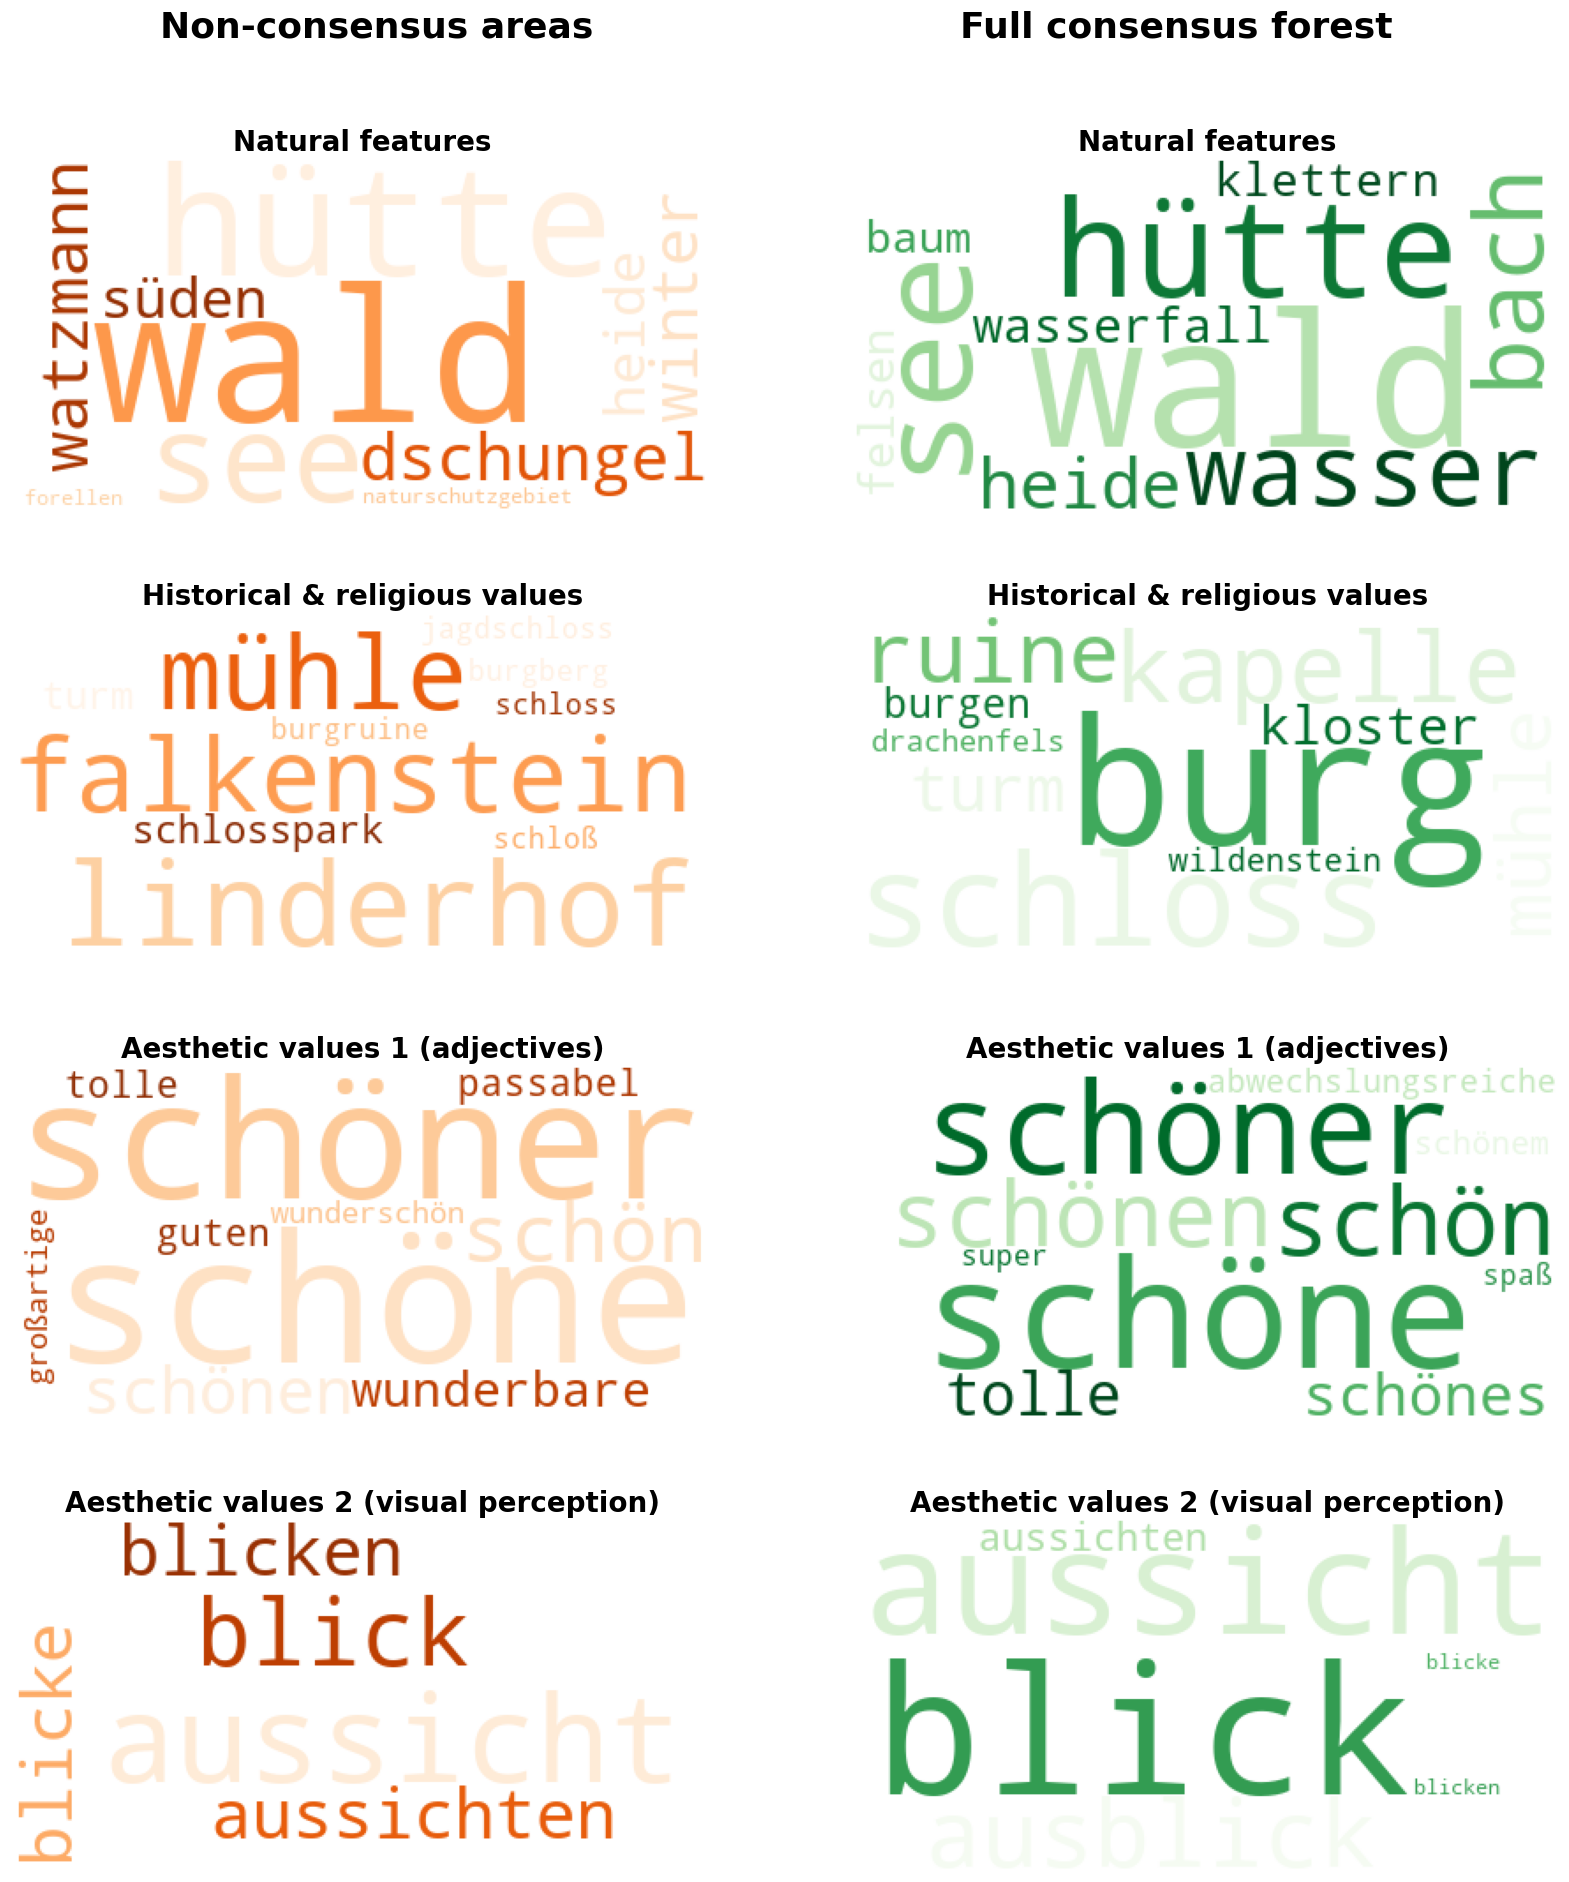

In [26]:
# STEP 3: WORD CLOUDS (ALL)

# Create a function to count the token frequencies for each cluster 
def get_cluster_freq(df, clus_num):
    token_list = df.loc[df["cluster"] == clus_num, "token"]
    delimiter = " " 
    join_str = delimiter.join(token_list)
    freqs = Counter(join_str.split())
    return freqs

# Create empty lists for storing the word cloud plots 
all_wc_c3 = []
all_wc_c6 = []

# For each cluster number use the get_cluster_freq function to get token frequencies,
# input those frequencies into the WordCloud generator and append each wc to list
# IMPORTANT: I HAVE LIMITED TO SHOW TOP 10 TOKENS IN EACH CLUSTER

# Generate class 3 word clouds (order is based on freq order from RQ2)
for clus_num in [8, 4, 3, 11]:  
    freqs = get_cluster_freq(filtered_clusters_c3, clus_num)
    wc = WordCloud(background_color='white', 
                   colormap='Oranges', 
                   max_words=10).generate_from_frequencies(freqs)
    all_wc_c3.append(wc)

# Generate class 6 word clouds (order is based on freq order from RQ2)
for clus_num in [8, 4, 3, 11]:  
    freqs = get_cluster_freq(filtered_clusters_c6, clus_num)
    wc = WordCloud(background_color='white', 
                   colormap='Greens', 
                   max_words=10).generate_from_frequencies(freqs)
    all_wc_c6.append(wc)

# Use the same titles AND order as from RQ2
all_titles = ["Natural features", "Historical & religious values", 
              "Aesthetic values 1 (adjectives)", "Aesthetic values 2 (visual perception)"]

# Create a single figure with 4 rows and 2 columns
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 22))

# Iterate through each word cloud to plot (class 3 in 1st column, class 6 in 2nd column) 
for i in range(4):
    # Class 3 word clouds
    axes[i, 0].imshow(all_wc_c3[i])
    axes[i, 0].axis('off')
    axes[i, 0].set_title(all_titles[i], fontsize=20, fontweight="bold")

    # Class 6 word clouds
    axes[i, 1].imshow(all_wc_c6[i])
    axes[i, 1].axis('off')
    axes[i, 1].set_title(all_titles[i], fontsize=20, fontweight="bold")

# Adjust white space at the top to fit in main titles and adjust space between rows
plt.subplots_adjust(top=0.90, hspace=0.2)

# Add column titles (first two numbers control the position)
fig.text(0.20, 0.95, "Non-consensus areas", fontsize=26, fontweight='bold')
fig.text(0.60, 0.95, "Full consensus forest", fontsize=26, fontweight='bold')

# Save the figure (this needs to go before plt.show otherwise saved output is blank)
plt.savefig('./outputs/figures/rq3_word_clouds_all.png', bbox_inches='tight')

# Display figure
plt.show()

In [10]:
# STEP 3: CLASS COMPARISON

# Get the total counts across all clusters for each class
# Natura only
c3_natura_total_token_count = len(filtered_clusters_natura_c3)
c6_natura_total_token_count = len(filtered_clusters_natura_c6)
# All
c3_total_token_count = len(filtered_clusters_c3)
c6_total_token_count = len(filtered_clusters_c6)

print(f"Total Tokens for Natura only Class 3: {c3_natura_total_token_count}")
print(f"Total Tokens for Natura only Class 6: {c6_natura_total_token_count}")
print("-------------------------")
print(f"Total Tokens for all Class 3: {c3_total_token_count}")
print(f"Total Tokens for all Class 6: {c6_total_token_count}")

Total Tokens for Natura only Class 3: 66
Total Tokens for Natura only Class 6: 2202
-------------------------
Total Tokens for all Class 3: 153
Total Tokens for all Class 6: 2700


In [11]:
# STEP 3: CLUSTER COMPARISON

# Create dfs for storing total number of tokens for each cluster for each class
c3_natura_token_counts_df = pd.DataFrame()
c6_natura_token_counts_df = pd.DataFrame()

c3_token_counts_df = pd.DataFrame()
c6_token_counts_df = pd.DataFrame()

# Create column for cluster names 
# note that all_titles is defined in word cloud code
c3_natura_token_counts_df["cluster_name"] = all_titles
c6_natura_token_counts_df["cluster_name"] = all_titles

c3_token_counts_df["cluster_name"] = all_titles
c6_token_counts_df["cluster_name"] = all_titles

# Create empty list for storing counts per cluster for each class
c3_natura_token_counts = []
c6_natura_token_counts = []

c3_token_counts = []
c6_token_counts = []

# Count tokens per cluster and append to list (class 3) w CUSTOM ORDER to match titles - NATURA ONLY
for clus_num in [8, 4, 3, 11]:
    count = len(filtered_clusters_natura_c3[filtered_clusters_natura_c3["cluster"] == clus_num])
    c3_natura_token_counts.append(count)

# Count tokens per cluster and append to list (class 6) w CUSTOM ORDER to match titles - NATURA ONLY
for clus_num in [8, 4, 3, 11]:
    count = len(filtered_clusters_natura_c6[filtered_clusters_natura_c6["cluster"] == clus_num])
    c6_natura_token_counts.append(count)

# Count tokens per cluster and append to list (class 3) w CUSTOM ORDER to match titles - ALL
for clus_num in [8, 4, 3, 11]:
    count = len(filtered_clusters_c3[filtered_clusters_c3["cluster"] == clus_num])
    c3_token_counts.append(count)

# Count tokens per cluster and append to list (class 6) w CUSTOM ORDER to match titles - ALL
for clus_num in [8, 4, 3, 11]:
    count = len(filtered_clusters_c6[filtered_clusters_c6["cluster"] == clus_num])
    c6_token_counts.append(count)

# Combine count lists and add to dfs
c3_natura_token_counts_df["token_count"] = c3_natura_token_counts 
c6_natura_token_counts_df["token_count"] = c6_natura_token_counts 

c3_token_counts_df["token_count"] = c3_token_counts 
c6_token_counts_df["token_count"] = c6_token_counts 

# Check
#c3_token_counts_df, c6_token_counts_df


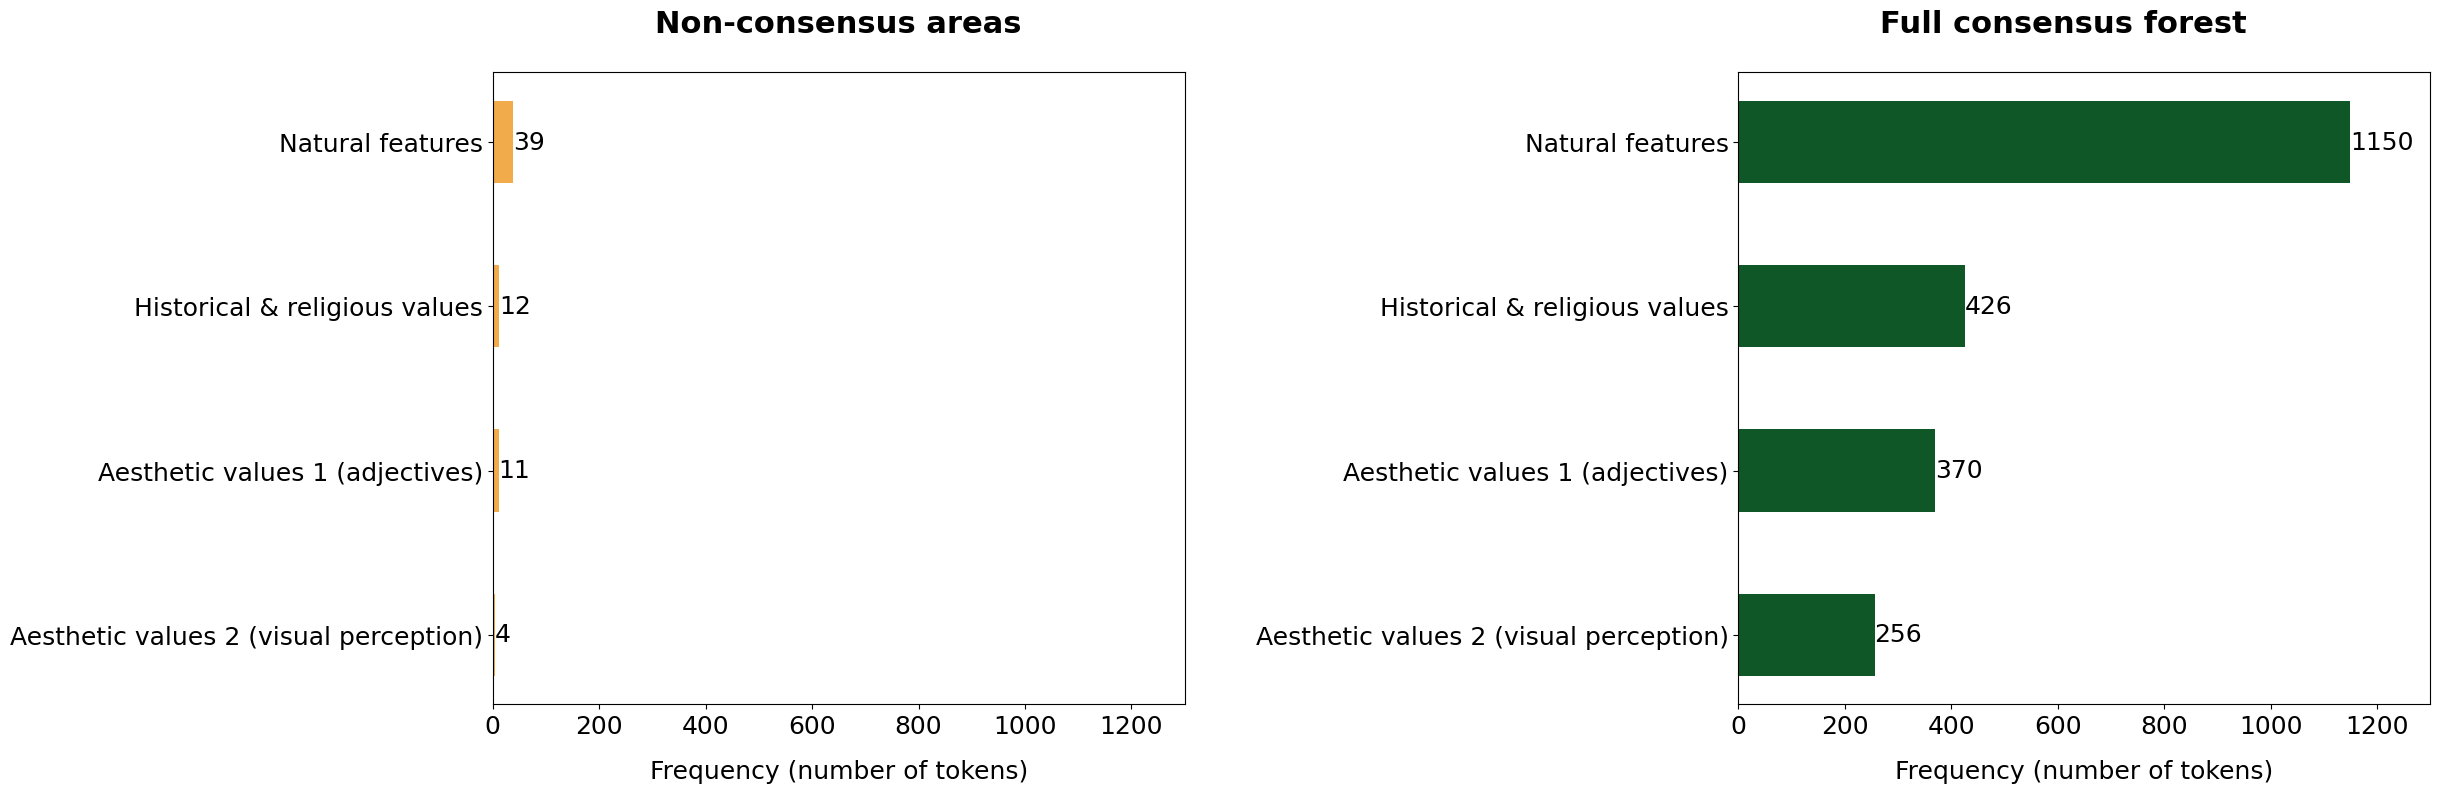

In [21]:
# STEP 3: CLUSTER COMPARISON - NATURA ONLY
# Create horizontal bar charts for token counts per cluster for each class

# Set up fig and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))

# Set up horizontal bar charts
bar_chart_nat_c3 = axes[0].barh(c3_natura_token_counts_df["cluster_name"], 
                                c3_natura_token_counts_df["token_count"],
                                color = "#F1AB4A",
                                height = 0.5)

bar_chart_nat_c6 = axes[1].barh(c6_natura_token_counts_df["cluster_name"], 
                                c6_natura_token_counts_df["token_count"],
                                color = "#0F5726",
                                height = 0.5)

# Customise yaxis order, set up labels and extend xlim to fit value labels
axes[0].invert_yaxis()  
axes[0].set_xlabel('Frequency (number of tokens)', fontsize=18, labelpad=15)
axes[0].bar_label(bar_chart_nat_c3, fontsize=18)
axes[0].tick_params(axis='y', labelsize=18)
axes[0].tick_params(axis='x', labelsize=18)
axes[0].set_xlim(right=1300) 

axes[1].invert_yaxis() 
axes[1].set_xlabel('Frequency (number of tokens)', fontsize=18, labelpad=15)
axes[1].bar_label(bar_chart_nat_c6, fontsize=18)
axes[1].tick_params(axis='y', labelsize=18)
axes[1].tick_params(axis='x', labelsize=18)
axes[1].set_xlim(right=1300) 

# Add column titles (first two numbers control the position)
fig.text(0.19, 0.95, "Non-consensus areas", fontsize=22, fontweight='bold')
fig.text(0.68, 0.95, "Full consensus forest", fontsize=22, fontweight='bold')

# Adjust white space at the top to fit in main titles and adjust space between rows/columns
plt.subplots_adjust(top=0.90, hspace=0.3, wspace=0.8)

# Save the combined figure (this needs to go before plt.show otherwise saved output is blank)
plt.savefig('./outputs/figures/rq3_cluster_counts_per_class_natura_only.png', bbox_inches='tight')

# Show plot
plt.show()


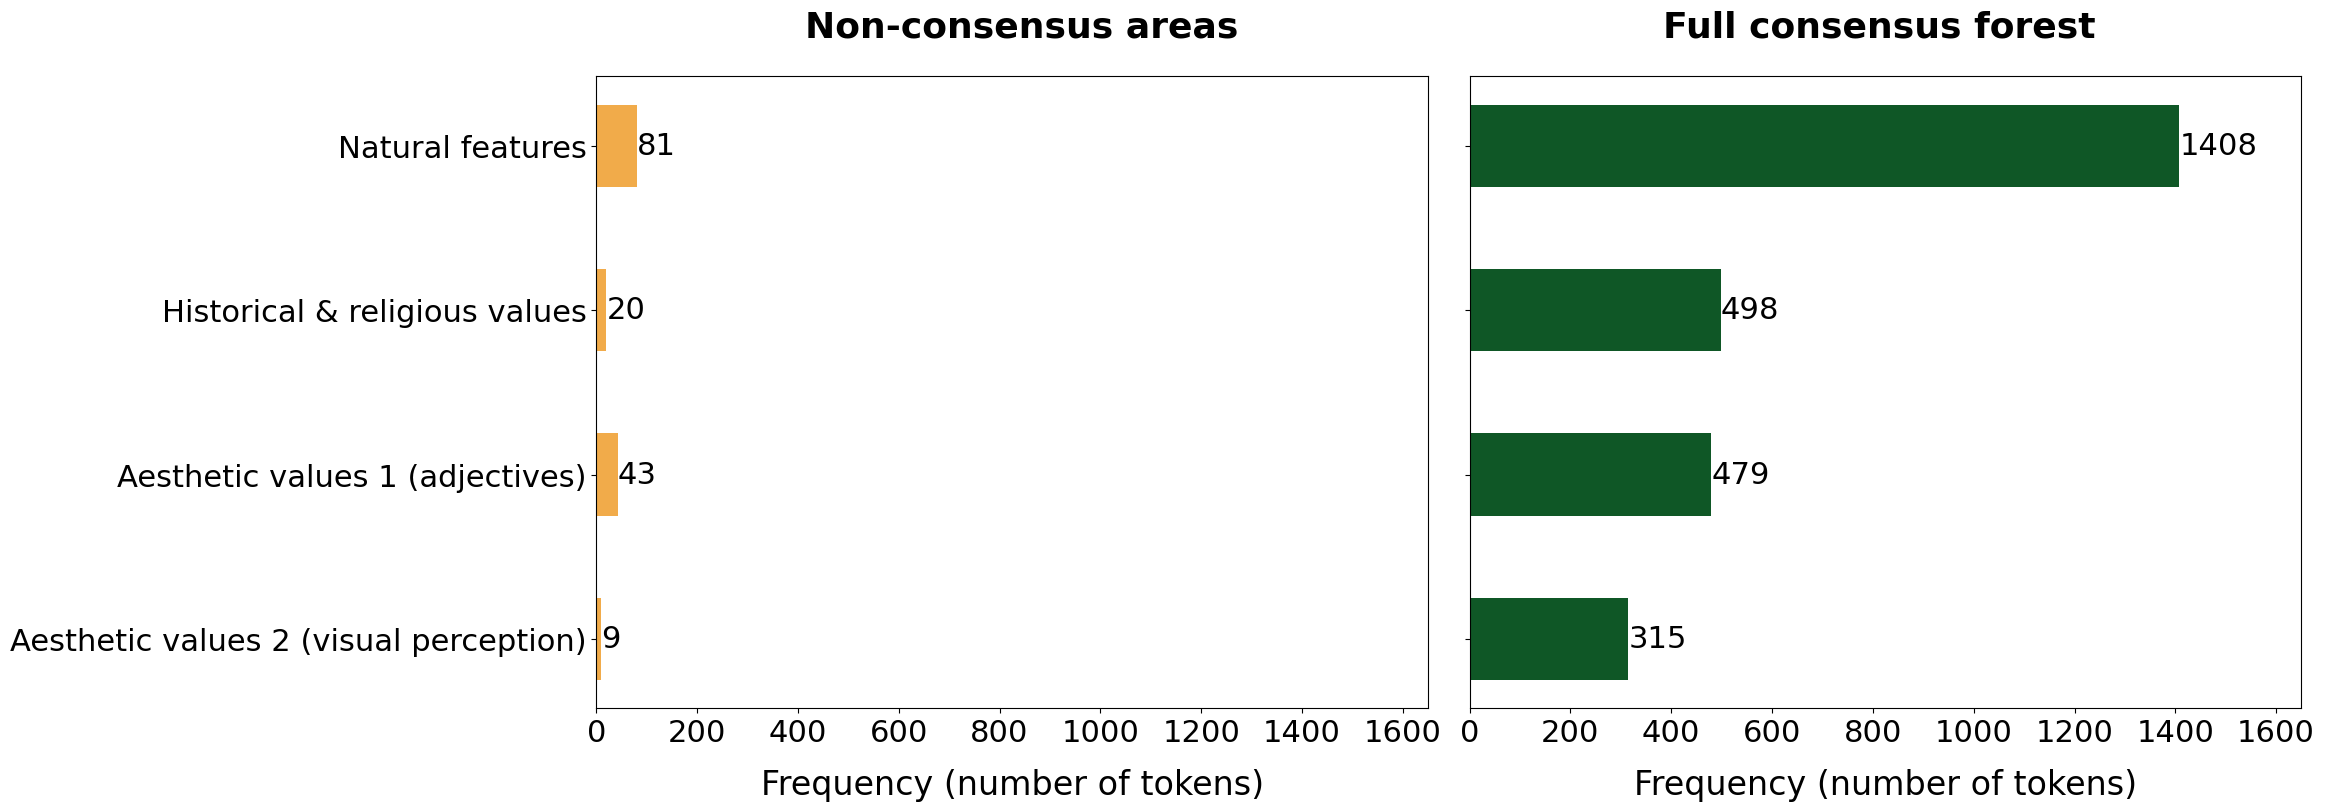

In [22]:
# STEP 3: CLUSTER COMPARISON - ALL
# Create horizontal bar charts for token counts per cluster for each class

# Set up fig and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))

# Set up horizontal bar charts
bar_chart_c3 = axes[0].barh(c3_token_counts_df["cluster_name"], 
                            c3_token_counts_df["token_count"],
                            color = "#F1AB4A",
                            height = 0.5)

bar_chart_c6 = axes[1].barh(c6_token_counts_df["cluster_name"], 
                            c6_token_counts_df["token_count"],
                            color = "#0F5726",
                            height = 0.5)

# Customise yaxis order, set up labels and extend xlim to fit value labels
axes[0].invert_yaxis()  
axes[0].set_xlabel('Frequency (number of tokens)', fontsize=24, labelpad=15)
axes[0].bar_label(bar_chart_c3, fontsize=22)
axes[0].tick_params(axis='y', labelsize=22)
axes[0].tick_params(axis='x', labelsize=22)
axes[0].set_xlim(right=1650) 

axes[1].invert_yaxis() 
axes[1].set_xlabel('Frequency (number of tokens)', fontsize=24, labelpad=15)
axes[1].bar_label(bar_chart_c6, fontsize=22)
axes[1].yaxis.set_ticklabels([])
axes[1].tick_params(axis='x', labelsize=22)
axes[1].set_xlim(right=1650) 

# Add column titles (first two numbers control the position)
fig.text(0.22, 0.95, "Non-consensus areas", fontsize=26, fontweight='bold')
fig.text(0.61, 0.95, "Full consensus forest", fontsize=26, fontweight='bold')

# Adjust white space at the top to fit in main titles and adjust space between rows/columns
plt.subplots_adjust(top=0.90, hspace=0.3, wspace=0.05)

# Save the combined figure (this needs to go before plt.show otherwise saved output is blank)
plt.savefig('./outputs/figures/rq3_cluster_counts_per_class_all.png', bbox_inches='tight')

# Show plot
plt.show()


In [23]:
# STEP 3: CLUSTER MEMBERSHIP - TOKEN COMPARISON

# Create function for getting the frequenies for each token (using another function from above)
def cluster_token_freqs(df, clus_range):
    clus_freqs = []
    for clus_num in clus_range:
        clus_freq = get_cluster_freq(df, clus_num)
        clus_freqs.append(clus_freq)
    return clus_freqs

# Run the cluster_token_freqs function for each cluster for class 3 and 6
c3_nat_clus3, c3_nat_clus4, c3_nat_clus8, c3_nat_clus11 = cluster_token_freqs(filtered_clusters_natura_c3, [3, 4, 8, 11])
c6_nat_clus3, c6_nat_clus4, c6_nat_clus8, c6_nat_clus11 = cluster_token_freqs(filtered_clusters_natura_c6, [3, 4, 8, 11])

c3_clus3, c3_clus4, c3_clus8, c3_clus11 = cluster_token_freqs(filtered_clusters_c3, [3, 4, 8, 11])
c6_clus3, c6_clus4, c6_clus8, c6_clus11 = cluster_token_freqs(filtered_clusters_c6, [3, 4, 8, 11])

# Create function for generating dfs with top 10 tokens from each cluster 
def top10_tokens(counter_obj):
    top10_df = pd.DataFrame.from_records(counter_obj.most_common(10), columns=['token','count'])
    return top10_df

# Use function for creating dfs per class and cluster (for Natura only & All)
c3_nat_clus3_top10_df = top10_tokens(c3_nat_clus3)
c3_nat_clus4_top10_df = top10_tokens(c3_nat_clus4)
c3_nat_clus8_top10_df = top10_tokens(c3_nat_clus8)
c3_nat_clus11_top10_df = top10_tokens(c3_nat_clus11)

c6_nat_clus3_top10_df = top10_tokens(c6_nat_clus3)
c6_nat_clus4_top10_df = top10_tokens(c6_nat_clus4)
c6_nat_clus8_top10_df = top10_tokens(c6_nat_clus8)
c6_nat_clus11_top10_df = top10_tokens(c6_nat_clus11)

c3_clus3_top10_df = top10_tokens(c3_clus3)
c3_clus4_top10_df = top10_tokens(c3_clus4)
c3_clus8_top10_df = top10_tokens(c3_clus8)
c3_clus11_top10_df = top10_tokens(c3_clus11)

c6_clus3_top10_df = top10_tokens(c6_clus3)
c6_clus4_top10_df = top10_tokens(c6_clus4)
c6_clus8_top10_df = top10_tokens(c6_clus8)
c6_clus11_top10_df = top10_tokens(c6_clus11)

# Check
#c3_clus5_top10_df


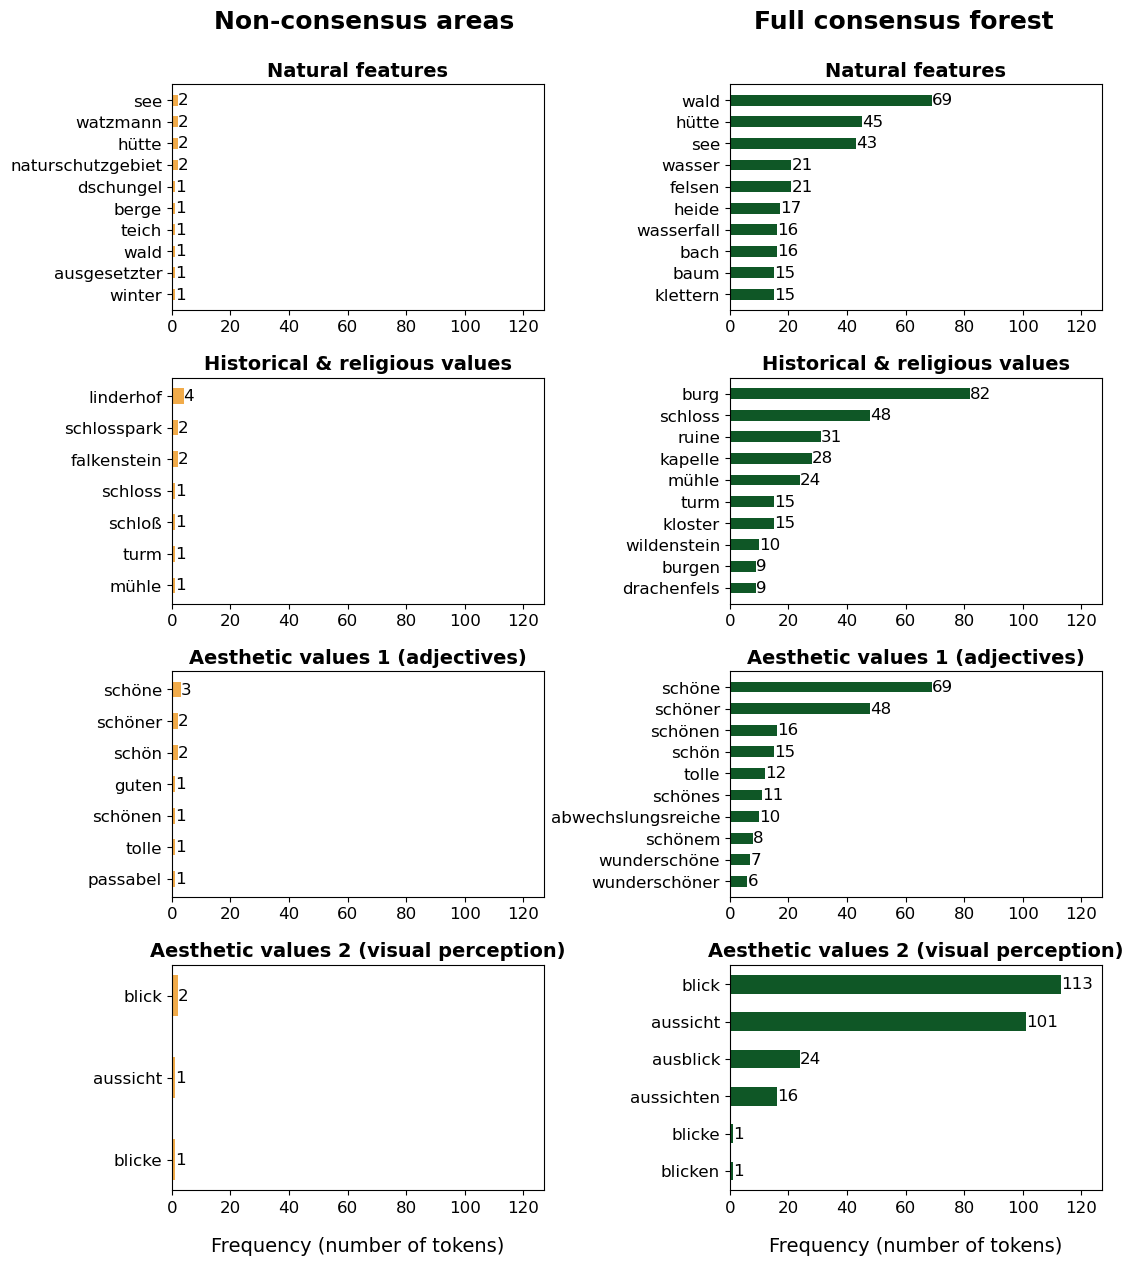

In [24]:
# STEP 3: CLUSTER MEMBERSHIP - TOKEN COMPARISON - NATURA ONLY
# Create horizontal bar charts for individual token counts per cluster for each class

# Create a list of the dfs to plot (one per class, in CUSTOM ORDER)
c3_nat_token_count_list = [c3_nat_clus8_top10_df, c3_nat_clus4_top10_df, c3_nat_clus3_top10_df, c3_nat_clus11_top10_df]
c6_nat_token_count_list = [c6_nat_clus8_top10_df, c6_nat_clus4_top10_df, c6_nat_clus3_top10_df, c6_nat_clus11_top10_df]

# Set up figs and axes
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 14))

# Iterate through each word cloud to plot (class 3 in 1st column, class 6 in 2nd column) 
# note that all_titles is defined in word cloud code
for i in range(4):
    # Class 3 plots
    bar_chart_c3 = axes[i, 0].barh(c3_nat_token_count_list[i]["token"], 
                                   c3_nat_token_count_list[i]["count"],
                                   color = "#F1AB4A",
                                   height = 0.5)
    axes[i, 0].invert_yaxis()
    axes[i, 0].set_title(all_titles[i], fontsize=14, fontweight="bold")
    axes[i, 0].set_xlim(right=127)
    axes[i, 0].bar_label(bar_chart_c3, fontsize=12)
    axes[i, 0].tick_params(axis='y', labelsize=12)
    axes[i, 0].tick_params(axis='x', labelsize=12)
    axes[3, 0].set_xlabel('Frequency (number of tokens)', fontsize=14, labelpad=15)

    # Class 6 plots
    bar_chart_c6 = axes[i, 1].barh(c6_nat_token_count_list[i]["token"], 
                                   c6_nat_token_count_list[i]["count"],
                                   color = "#0F5726",
                                   height = 0.5)
    axes[i, 1].invert_yaxis()
    axes[i, 1].set_title(all_titles[i], fontsize=14, fontweight="bold")
    axes[i, 1].set_xlim(right=127)
    axes[i, 1].bar_label(bar_chart_c6, fontsize=12)
    axes[i, 1].tick_params(axis='y', labelsize=12)
    axes[i, 1].tick_params(axis='x', labelsize=12)
    axes[3, 1].set_xlabel('Frequency (number of tokens)', fontsize=14, labelpad=15)

# Adjust white space at the top to fit in main titles and adjust space between rows/columns
plt.subplots_adjust(top=0.90, hspace=0.2, wspace=0.3)

# Add column titles (first two numbers control the position)
fig.text(0.16, 0.94, "Non-consensus areas", fontsize=18, fontweight='bold')
fig.text(0.61, 0.94, "Full consensus forest", fontsize=18, fontweight='bold')

# Adjust white space at the top to fit in main titles and adjust space between rows/columns
plt.subplots_adjust(top=0.90, hspace=0.3, wspace=0.5)

# Save the combined figure (this needs to go before plt.show otherwise saved output is blank)
plt.savefig('./outputs/figures/rq3_token_counts_per_cluster_class_natura_only.png', bbox_inches='tight')

# Show plot
plt.show()


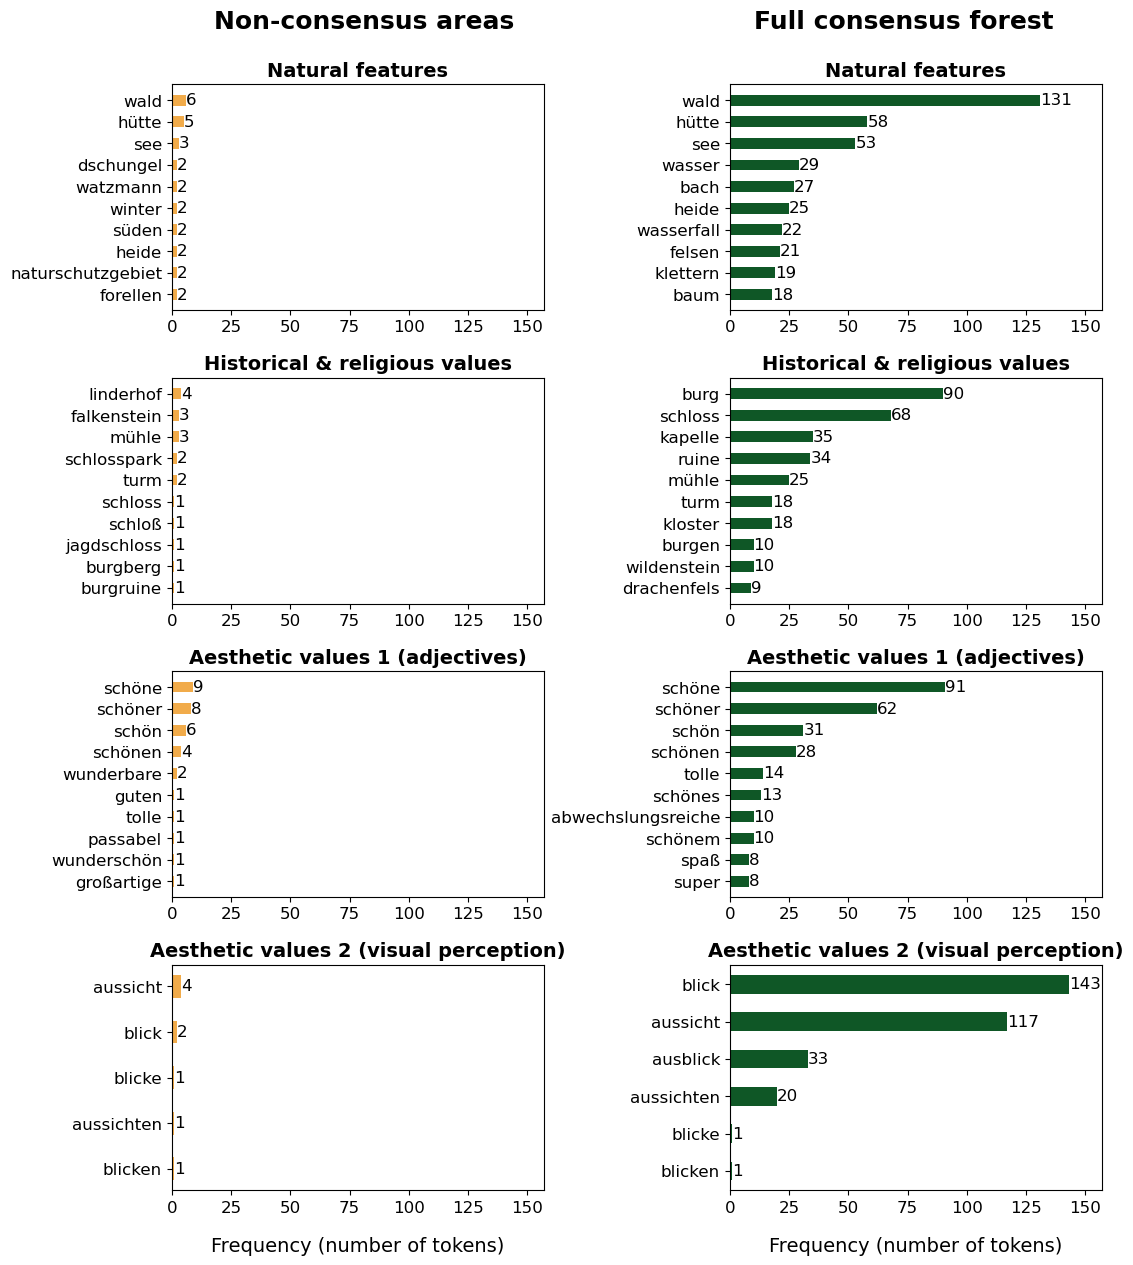

In [19]:
# STEP 3: CLUSTER MEMBERSHIP - TOKEN COMPARISON - ALL
# Create horizontal bar charts for individual token counts per cluster for each class

# Create a list of the dfs to plot (one per class, in CUSTOM ORDER)
c3_token_count_list = [c3_clus8_top10_df, c3_clus4_top10_df, c3_clus3_top10_df, c3_clus11_top10_df]
c6_token_count_list = [c6_clus8_top10_df, c6_clus4_top10_df, c6_clus3_top10_df, c6_clus11_top10_df]

# Set up figs and axes
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 14))

# Iterate through each word cloud to plot (class 3 in 1st column, class 6 in 2nd column) 
# note that all_titles is defined in word cloud code
for i in range(4):
    # Class 3 plots
    bar_chart_c3 = axes[i, 0].barh(c3_token_count_list[i]["token"], 
                                   c3_token_count_list[i]["count"],
                                   color = "#F1AB4A",
                                   height = 0.5)
    axes[i, 0].invert_yaxis()
    axes[i, 0].set_title(all_titles[i], fontsize=14, fontweight="bold")
    axes[i, 0].set_xlim(right=157)
    axes[i, 0].bar_label(bar_chart_c3, fontsize=12)
    axes[i, 0].tick_params(axis='y', labelsize=12)
    axes[i, 0].tick_params(axis='x', labelsize=12)
    axes[3, 0].set_xlabel('Frequency (number of tokens)', fontsize=14, labelpad=15)

    # Class 6 plots
    bar_chart_c6 = axes[i, 1].barh(c6_token_count_list[i]["token"], 
                                   c6_token_count_list[i]["count"],
                                   color = "#0F5726",
                                   height = 0.5)
    axes[i, 1].invert_yaxis()
    axes[i, 1].set_title(all_titles[i], fontsize=14, fontweight="bold")
    axes[i, 1].set_xlim(right=157)
    axes[i, 1].bar_label(bar_chart_c6, fontsize=12)
    axes[i, 1].tick_params(axis='y', labelsize=12)
    axes[i, 1].tick_params(axis='x', labelsize=12)
    axes[3, 1].set_xlabel('Frequency (number of tokens)', fontsize=14, labelpad=15)

# Adjust white space at the top to fit in main titles and adjust space between rows/columns
plt.subplots_adjust(top=0.90, hspace=0.2, wspace=0.3)

# Add column titles (first two numbers control the position)
fig.text(0.16, 0.94, "Non-consensus areas", fontsize=18, fontweight='bold')
fig.text(0.61, 0.94, "Full consensus forest", fontsize=18, fontweight='bold')

# Adjust white space at the top to fit in main titles and adjust space between rows/columns
plt.subplots_adjust(top=0.90, hspace=0.3, wspace=0.5)

# Save the combined figure (this needs to go before plt.show otherwise saved output is blank)
plt.savefig('./outputs/figures/rq3_token_counts_per_cluster_class_all.png', bbox_inches='tight')

# Show plot
plt.show()
